# 12.2 전이 학습의 구현
 

리스트12.1 각 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.optimizers import adam_v2

optimizer = adam_v2.Adam()

img_size = 64  # 이미지의 폭과 높이
n_channel = 3  # 채널 수
n_mid = 256  # 중간층의 뉴런 수

batch_size = 32
epochs = 20

리스트12.2 VGG16의 도입

In [2]:
from tensorflow.keras.applications import VGG16

model_vgg16 = VGG16(weights="imagenet",  # ImageNet에서 학습한 파라미터를 사용
                 include_top=False,  # 전결합층을 포함하지 않는다
                 input_shape=(img_size, img_size, n_channel))  # 입력의 형태
model_vgg16.summary()

58900480/58889256 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_____________________________________________________________

리스트12.3 CIFAR-10의 도입


Original size: (10000, 32, 32, 3)
Input size: (10000, 64, 64, 3)


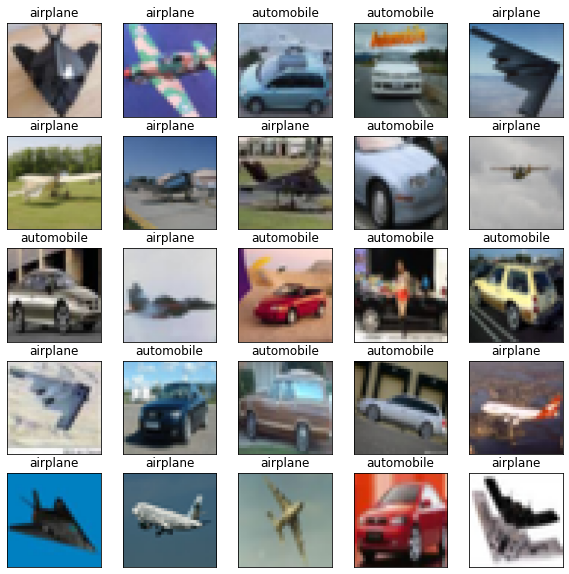

In [3]:
from tensorflow.keras.datasets import cifar10

(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# 라벨이 0과 1의 데이터만 꺼낸다
t_train = t_train.reshape(-1)
t_test = t_test.reshape(-1)
x_train = x_train[t_train <= 1]
t_train = t_train[t_train <= 1]
x_test = x_test[t_test <= 1]
t_test = t_test[t_test <= 1]

print("Original size:", x_train.shape)

# 이미지를 2배로 확대
x_train = x_train.repeat(2, axis=1).repeat(2, axis=2)
x_test = x_test.repeat(2, axis=1).repeat(2, axis=2)

print("Input size:", x_train.shape)

n_image = 25
rand_idx = np.random.randint(0, len(x_train), n_image)
cifar10_labels = np.array(["airplane", "automobile"])
plt.figure(figsize=(10,10))  # 표시 영역의 크기
for i in range(n_image):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_train[rand_idx[i]])
    label = cifar10_labels[t_train[rand_idx[i]]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 라벨과 눈금을 비표시로

리스트12.4 전이 학습용의 모델을 구축한다


In [4]:
model = Sequential()
model.add(model_vgg16)

#model.add(Dense(256, input_shape=(128,)))
model.add(Flatten())  # 1차원의 배열로 변환
model.add(Dense(n_mid))
model.add(Activation("relu"))
model.add(Dropout(0.5))  # 드롭 아웃
model.add(Dense(1))
model.add(Activation("sigmoid"))

model_vgg16.trainable = False  # 훈련한 층은 훈련하지 않는다

model.compile(optimizer=adam_v2.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
#model.summary()


리스트12.5 모델의 학습

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train = x_train / 255  # 0에서 1의 범위에 넣는다
x_test = x_test / 255

# 데이터 확장
generator = ImageDataGenerator(
           rotation_range=0.2,
           width_shift_range=0.2,
           height_shift_range=0.2,
           shear_range=10,
           zoom_range=0.2,
           horizontal_flip=True)
generator.fit(x_train)

# 훈련
history = model.fit(generator.flow(x_train, t_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, t_test))

Epoch 1/20
    438/Unknown - 201s 458ms/step - loss: 0.2452 - accuracy: 0.8998

리스트12.6 학습의 추이를 표시한다

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 훈련용 데이터의 오차
train_acc = history.history['accuracy']  # 훈련용 데이터의 정밀도
val_loss = history.history['val_loss']  # 검증용 데이터의 오차
val_acc = history.history['val_accuracy']  # 검증용 데이터의 정밀도

plt.plot(np.arange(len(train_loss)), train_loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.show()